In [30]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,f1_score, roc_curve, auc,roc_auc_score
from Include.MLSMOTE import get_tail_label,get_index,get_minority_instace,MLSMOTE
from scipy.stats import yeojohnson

找出适合OneHotEncoder的数据

https://zhuanlan.zhihu.com/p/686452650

In [31]:
# 加载数据
x_train = np.load('../Training data/X_train.npy')  # 特征 (1000, 111)
y_train = np.load('../Training data/y_train.npy')  # 目标 (1000, 11)
x_test=np.load("../Testing data/X_test.npy")


x_train = pd.DataFrame(x_train).rename(columns={i: f"x_{i}" for i in range(111)})
y_train = pd.DataFrame(y_train).rename(columns={i: f"y_{i}" for i in range(11)})
x_test = pd.DataFrame(x_test).rename(columns={i: f"x_{i}" for i in range(111)})

#中位数填补
for column in x_train.columns:
    x_train.fillna({column: x_train[column].median()}, inplace=True)
    x_test.fillna({column: x_test[column].median()}, inplace=True)


# 找出非零值少于1%的列
threshold = 0.01  # 或者任何认为合适的值
cols_to_drop = [col for col in x_train.columns if (x_train[col] != 0).mean() < threshold]
# cols_to_drop += ["x_8",  "x_26", "x_29", "x_30", "x_32", "x_39", "x_50", "x_53", "x_54", "x_64", "x_68", "x_71", "x_93", "x_102"] #补充的一些特殊列
# 删除这些列
x_train.drop(columns=cols_to_drop, inplace=True)
x_test.drop(columns=cols_to_drop, inplace=True)

# Yeo-Johnson 变换
x_train = x_train.apply(lambda x: yeojohnson(x)[0])
x_test = x_test.apply(lambda x: yeojohnson(x)[0])

# 特征缩放
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)



print(x_train.shape)
print(x_test.shape)

(1000, 72)
(700, 72)


使用MLSMOTE重采样

In [32]:
# 寻找尾部标签
tail_labels = get_tail_label(y_train)

# 获取尾部标签的索引
indices = get_index(y_train)

# 获取尾部标签的样本
X_sub, y_sub = get_minority_instace(x_train, y_train)

# 应用MLSMOTE来增强数据集
X_resampled, y_resampled = MLSMOTE(X_sub, y_sub, 0)  # 假设生成新样本

# 合并原始数据和生成的数据
X_train_final = pd.concat([x_train, X_resampled], ignore_index=True)
y_train_final = pd.concat([y_train, y_resampled], ignore_index=True)

# 划分出来百分之二十的测试集
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_final, y_train_final, test_size=0.2, random_state=42)
print(X_train.shape)
print(Y_train.shape)

(1414, 72)
(1414, 11)


NN部分

In [33]:
# 定义模型结构
shared_input = Input(shape=(X_train.shape[1], ), name='shared_input')
shared_layer = Dense(128, activation='relu')(shared_input)
shared_layer = Dense(128, activation='relu')(shared_layer)
shared_layer = Dense(64, activation='relu')(shared_layer)
shared_layer = Dense(32, activation='relu')(shared_layer)
 

定义Specific部分

In [34]:
outputs = []
for i in range(11):
    task_output = Dense(32,  activation='tanh', name=f'task_{i}_hidden')(shared_layer)
    task_output = Dense(1,  activation='sigmoid', name=f'task_{i}_output')(task_output)
    outputs.append(task_output)
outputs = Concatenate(axis=-1)(outputs)

训练模型并输出

In [35]:
model = Model(inputs=shared_input, outputs=outputs)
# 编译模型，添加精确率和召回率指标
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #将NN的值传入最终的separate models
    metrics=[
        tf.keras.metrics.Precision(name='precision', thresholds=[0.2, 0.5, 0.7, 0.8, 0.9, 0.95]),
        tf.keras.metrics.Recall(name='recall', thresholds=[0.2, 0.5, 0.7, 0.8, 0.9, 0.95]),
    ])


# 训练模型
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_valid, Y_valid))


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.6288 - precision: 0.1406 - recall: 0.1846 - val_loss: 0.6061 - val_precision: 0.2155 - val_recall: 0.1563
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5673 - precision: 0.1340 - recall: 0.1590 - val_loss: 0.6021 - val_precision: 0.1236 - val_recall: 0.1507
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5415 - precision: 0.2692 - recall: 0.1618 - val_loss: 0.5866 - val_precision: 0.3376 - val_recall: 0.1434
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5109 - precision: 0.3836 - recall: 0.1739 - val_loss: 0.5735 - val_precision: 0.4721 - val_recall: 0.1527
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4614 - precision: 0.7036 - recall: 0.2006 - val_loss: 0.5524 - val_precision: 0.5173 - val_recall: 0.1775
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4143 - precision: 0.6956 - recall: 0.2508 - val_loss: 0.5349 - val_precision: 0.6588 - val_recall: 0.2092
Epoc

In [36]:
# 计算模型在训练集上的精确率和召回率
train_precision = history.history['precision'] 
train_recall = history.history['recall']
train_loss = history.history['loss']

# 计算模型在验证集上的精确率和召回率
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_loss = history.history['val_loss']

# 打印训练集和验证集上的精确率和召回率
print(f'Train Precision: {train_precision[-1]}')
print(f'Validation Precision: {val_precision[-1]}')

print(f'Train Recall: {train_recall[-1]}')
print(f'Validation Recall: {val_recall[-1]}')

print(f'Train Loss: {train_loss[-1]}')
print(f'Validation Loss: {val_loss[-1]}')

Train Precision: [1. 1. 1. 1. 1. 1.]
Validation Precision: [0.79260594 0.8235294  0.84277344 0.8489635  0.859879   0.87916666]
Train Recall: [1. 1. 1. 1. 1. 1.]
Validation Recall: [0.7820285  0.772242   0.7677936  0.76512456 0.75889677 0.75088966]
Train Loss: 0.0005148272612132132
Validation Loss: 0.7589908242225647


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Average Accuracy: 0.6751412429378532
Macro F1 Score: 0.7947500958797901
Micro F1 Score: 0.7970615243342516
              precision    recall  f1-score   support

         y_0       0.79      0.69      0.73       102
         y_1       0.75      0.75      0.75        87
         y_2       0.87      0.76      0.81       102
         y_3       0.92      0.84      0.88        98
         y_4       0.82      0.82      0.82       102
         y_5       0.80      0.79      0.79        84
         y_6       0.78      0.71      0.74        96
         y_7       0.80      0.90      0.84        96
         y_8       0.86      0.82      0.84       142
         y_9       0.81      0.68      0.74       110
        y_10       0.86      0.74      0.80       105

   micro avg       0.82      0.77      0.80      1124
   macro avg       0.82      0.77      0.79      1124
weighted avg       0.82      0.77      0.80      1124
 samples avg       0.75      0.74      0.

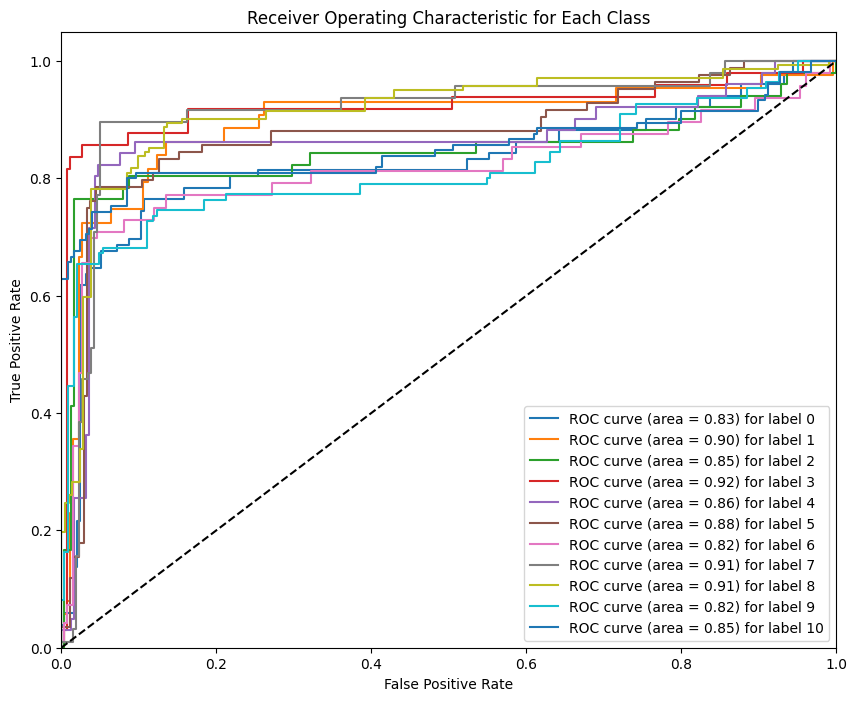

Micro-average AUC: 0.8703131222940246
Macro-average AUC: 0.8672923814953293


In [37]:

# 使用模型进行预测
Y_pred = model.predict(X_valid)

# 阈值处理，这里我们将0.5作为分类阈值
Y_pred_binary = (Y_pred > 0.5).astype(int)

# 计算平均精度
average_accuracy = accuracy_score(Y_valid, Y_pred_binary)
print("Average Accuracy:", average_accuracy)

# 计算宏观F1和微观F1
macro_f1 = f1_score(Y_valid, Y_pred_binary, average='macro')
micro_f1 = f1_score(Y_valid, Y_pred_binary, average='micro')
print("Macro F1 Score:", macro_f1)
print("Micro F1 Score:", micro_f1)

# 生成分类报告
report = classification_report(Y_valid, Y_pred_binary, target_names=[f'y_{i}' for i in range(Y_valid.shape[1])], zero_division=0)
print(report)

# 打印训练集和验证集上的最后一个epoch的精确率和召回率
print(f'Train Precision: {train_precision[-1]}')
print(f'Train Recall: {train_recall[-1]}')
print(f'Validation Precision: {val_precision[-1]}')
print(f'Validation Recall: {val_recall[-1]}')


# 使用模型进行预测获取概率输出
Y_pred_proba = model.predict(X_valid)

# 为每个类别绘制ROC曲线和计算AUC
plt.figure(figsize=(10, 8))
for i in range(Y_valid.shape[1]):
    fpr, tpr, _ = roc_curve(Y_valid.iloc[:, i], Y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for label {i}')

plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

# 计算总的微观和宏观平均AUC
micro_auc = roc_auc_score(Y_valid, Y_pred_proba, average="micro")
macro_auc = roc_auc_score(Y_valid, Y_pred_proba, average="macro")
print("Micro-average AUC:", micro_auc)
print("Macro-average AUC:", macro_auc)


In [38]:
y_hat = model.predict(x_test)

y_hat = (y_hat > 0.5).astype(int)

y_hat = pd.DataFrame(y_hat).rename(columns={i: f"y_pred_{i}" for i in range(11)})
y_hat

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


,y_pred_0,y_pred_1,y_pred_2,y_pred_3,y_pred_4,y_pred_5,y_pred_6,y_pred_7,y_pred_8,y_pred_9,y_pred_10
0,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,1,0,0
3,0,1,0,0,0,1,0,1,1,0,0
4,0,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
695,0,0,0,1,0,0,0,0,0,1,0
696,0,0,1,0,0,0,1,0,0,0,0
697,1,0,1,1,0,0,1,0,1,0,0
698,0,0,0,0,0,0,0,1,1,0,0


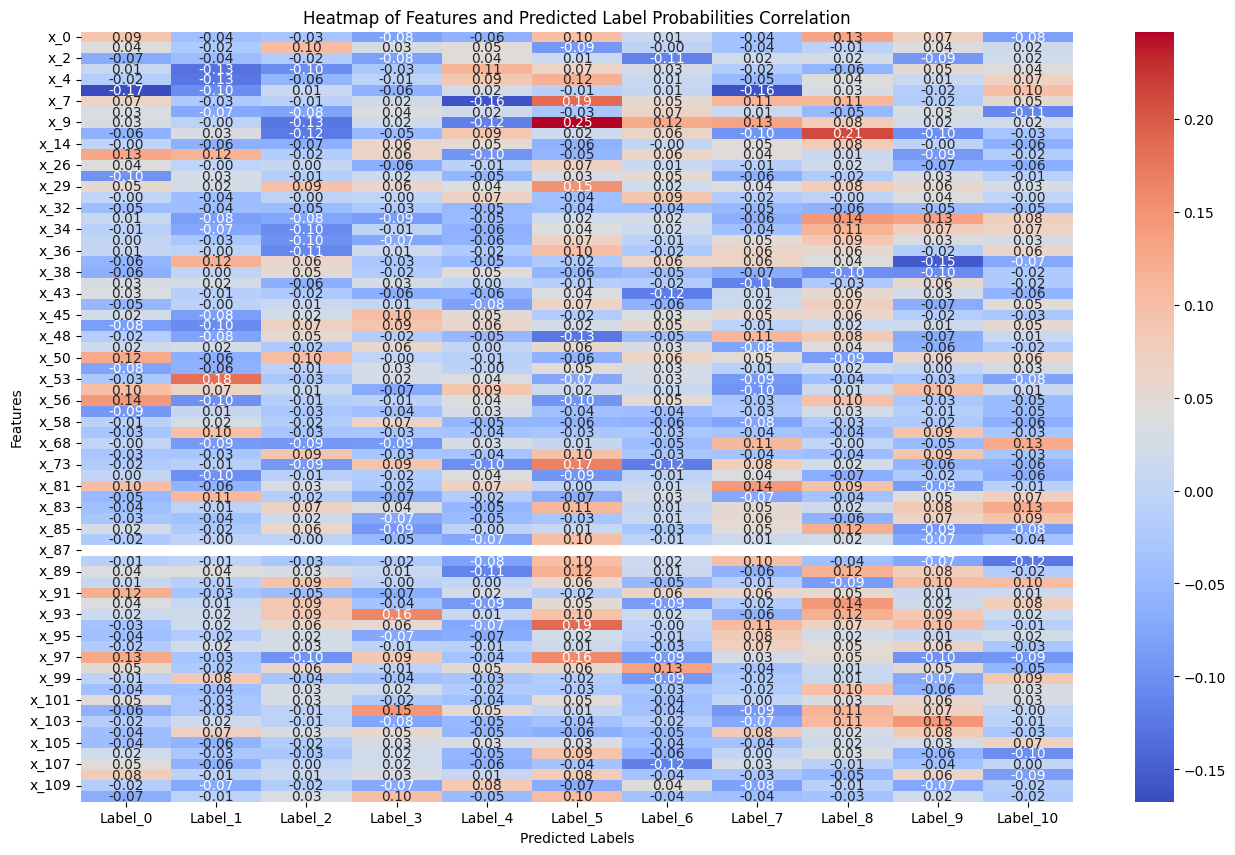

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 将预测概率转换为DataFrame
probabilities_df = pd.DataFrame(Y_pred_proba, columns=[f'Label_{i}' for i in range(Y_pred_proba.shape[1])])

# 将预测概率DataFrame与特征DataFrame合并
# 假设 X_valid 是特征数据
combined_df = pd.concat([X_valid.reset_index(drop=True), probabilities_df], axis=1)

# 计算特征与预测概率之间的相关矩阵
correlation_matrix = combined_df.corr()

# 提取与标签相关的相关性部分
labels_correlation = correlation_matrix.loc[:, probabilities_df.columns].iloc[:-len(probabilities_df.columns), :]

# 使用Seaborn绘制热力图
plt.figure(figsize=(16, 10))
sns.heatmap(labels_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Features and Predicted Label Probabilities Correlation')
plt.xlabel('Predicted Labels')
plt.ylabel('Features')
plt.show()

In [39]:
# with open('predict.txt', 'w') as file:
#     for line in y_hat:
#         file.write(str(line)+'\n')
# y_hat.to_csv('predicts.csv')